In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('BA_reviews.csv')

In [3]:
# Memisahkan status verifikasi dan isi review
df[['status', 'review_content']] = df['reviews'].str.extract(r'(✅ Trip Verified|Not Verified) \| (.+)')

In [4]:
df = df.drop(['reviews'], axis=1)

In [5]:
df['status'] = df['status'].apply(lambda x: 1 if x == '✅ Trip Verified' else 0)

In [6]:
df.head()

,status,review_content
0,0,While BA may have made some positive improve...
1,1,British Airways new Club Suite is a marked imp...
2,1,"Four very pleasant, on time flights with frie..."
3,0,We travel extensively over 25 years and tend...
4,1,Flight delayed an hour due to bad weather aro...


In [7]:
# Menghitung jumlah review berdasarkan status verifikasi
verification_counts = df['status'].value_counts()

print(verification_counts)

status
1    739
0    261
Name: count, dtype: int64


In [8]:
df.isnull().sum()

status             0
review_content    22
dtype: int64

In [9]:
df.count()

status            1000
review_content     978
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

status            0
review_content    0
dtype: int64

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus tanda baca dan angka
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    # Menghapus kata-kata umum (stopwords)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['processed_review'] = df['review_content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Langkah 3: Analisis Sentimen Menggunakan TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['processed_review'].apply(analyze_sentiment)

# Menampilkan beberapa hasil
print(df[['review_content', 'processed_review', 'sentiment']].head())

                                      review_content  \
0    While BA may have made some positive improve...   
1  British Airways new Club Suite is a marked imp...   
2   Four very pleasant, on time flights with frie...   
3    We travel extensively over 25 years and tend...   
4   Flight delayed an hour due to bad weather aro...   

                                    processed_review sentiment  
0  ba may made positive improvements club world p...  negative  
1  british airways new club suite marked improvem...  positive  
2  four pleasant time flights friendly helpful st...  positive  
3  travel extensively years tend use ba regular t...  positive  
4  flight delayed hour due bad weather around jfk...  negative  


In [14]:
df.head()

,status,review_content,processed_review,sentiment
0,0,While BA may have made some positive improve...,ba may made positive improvements club world p...,negative
1,1,British Airways new Club Suite is a marked imp...,british airways new club suite marked improvem...,positive
2,1,"Four very pleasant, on time flights with frie...",four pleasant time flights friendly helpful st...,positive
3,0,We travel extensively over 25 years and tend...,travel extensively years tend use ba regular t...,positive
4,1,Flight delayed an hour due to bad weather aro...,flight delayed hour due bad weather around jfk...,negative


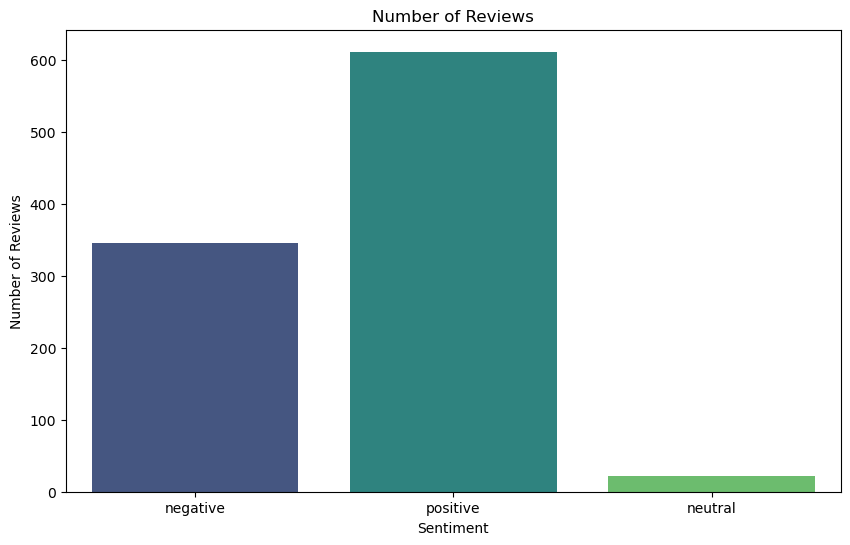

In [15]:
# Langkah 4: Visualisasi Distribusi Sentimen
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, hue = 'sentiment', palette='viridis')
plt.title('Number of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
#plt.savefig('sentiment_distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show();

In [16]:
df['sentiment'].value_counts()

sentiment
positive    611
negative    345
neutral      22
Name: count, dtype: int64

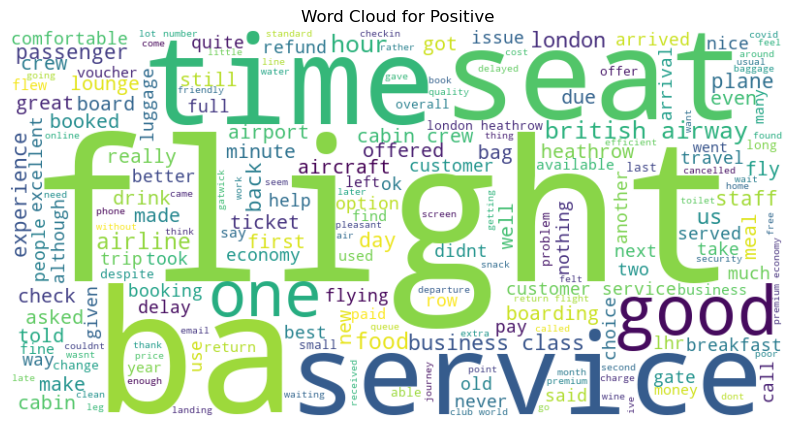

In [17]:
# Langkah 5: Word Cloud untuk Ulasan Positif
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['processed_review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive')
plt.axis('off')
#plt.savefig('wordcloud_positive.png', format='png', dpi=300, bbox_inches='tight')
plt.show();

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [19]:
# Buat fungsi untuk mendapatkan n-grams
def get_ngrams(texts, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    # Convert the single string into a list of strings for CountVectorizer
    X = vectorizer.fit_transform([texts])
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
    return ngram_freq

# Hitung frekuensi bigrams
bigram_freq = get_ngrams(positive_reviews, n=2)

In [20]:
# Ambil 10 bigrams teratas
common_bigrams = Counter(bigram_freq).most_common(10)

# Tampilkan hasil
print("10 Bigrams Teratas dalam Ulasan Positif:")
for bigram, freq in common_bigrams:
    print(f"{bigram}: {freq}")

10 Bigrams Teratas dalam Ulasan Positif:
british airways: 247
business class: 183
cabin crew: 140
customer service: 87
london heathrow: 61
return flight: 53
club world: 49
premium economy: 43
club europe: 38
first class: 38


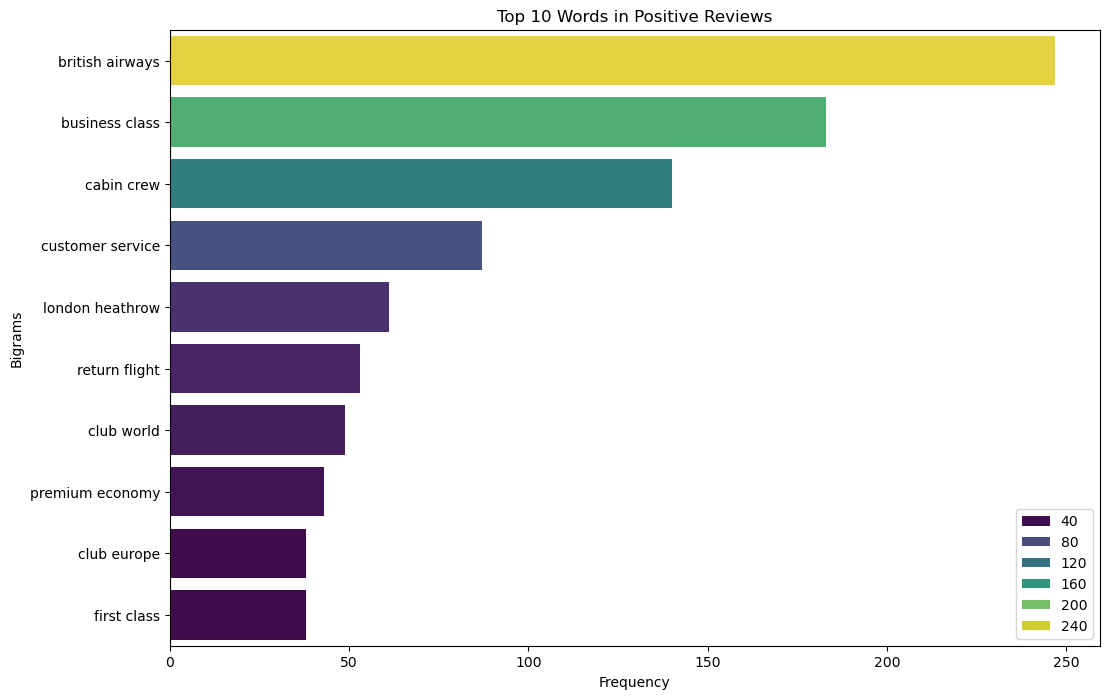

In [21]:
bigrams, freqs = zip(*common_bigrams)
plt.figure(figsize=(12, 8))
sns.barplot(x=list(freqs), y=list(bigrams), hue = list(freqs), palette='viridis')
plt.title('Top 10 Words in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
#plt.savefig('10 Bigrams for Positve.png', format='png', dpi=300, bbox_inches='tight')
plt.show();

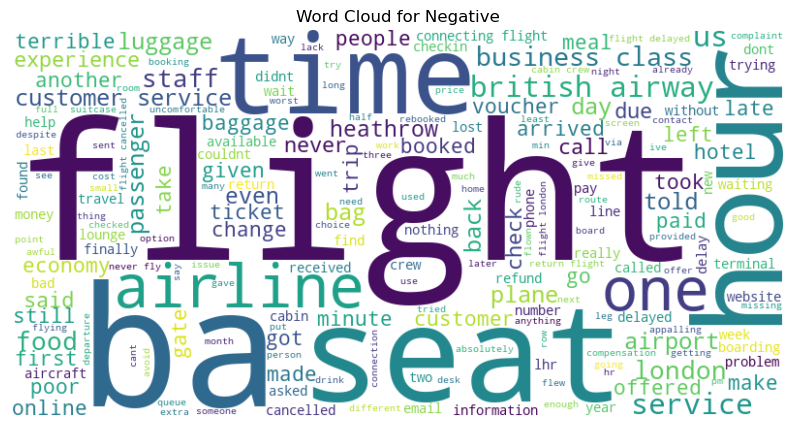

In [22]:
# Langkah 6: Word Cloud untuk Ulasan Negatif
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['processed_review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative')
plt.axis('off')
#plt.savefig('wordcloud_negative.png', format='png', dpi=300, bbox_inches='tight')
plt.show();

In [23]:
# Hitung frekuensi bigrams for negative reviews
bigram_freq = get_ngrams(negative_reviews, n=2)

In [24]:
# Ambil 10 bigrams teratas
common_bigrams = Counter(bigram_freq).most_common(10)

# Tampilkan hasil
print("10 Bigrams Teratas dalam Ulasan Negatif:")
for bigram, freq in common_bigrams:
    print(f"{bigram}: {freq}")

10 Bigrams Teratas dalam Ulasan Negatif:
british airways: 154
business class: 123
customer service: 100
connecting flight: 43
flight delayed: 34
cabin crew: 31
return flight: 30
flight cancelled: 27
flight london: 25
never fly: 24


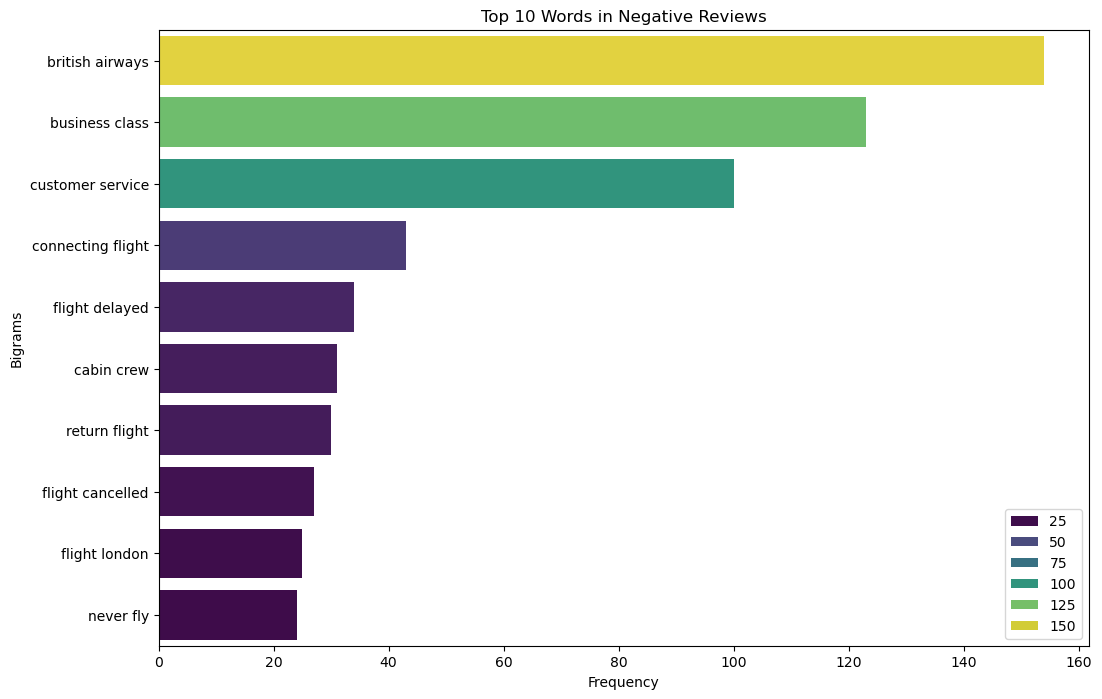

In [25]:
bigrams, freqs = zip(*common_bigrams)
plt.figure(figsize=(12, 8))
sns.barplot(x=list(freqs), y=list(bigrams), hue = list(freqs), palette='viridis')
plt.title('Top 10 Words in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
#plt.savefig('10 Bigrams for Negative.png', format='png', dpi=300, bbox_inches='tight')
plt.show();

In [26]:
# Deskripsi Statistik
sentiment_counts = df['sentiment'].value_counts()
print("Deskripsi Statistik Sentimen:")
print(sentiment_counts)

Deskripsi Statistik Sentimen:
sentiment
positive    611
negative    345
neutral      22
Name: count, dtype: int64


### Pemodelan Topik

In [27]:
from gensim import corpora
import gensim

In [28]:
# Tokenisasi
df['tokenized_review'] = df['processed_review'].apply(lambda x: x.split())

# Membuat kamus
dictionary = corpora.Dictionary(df['tokenized_review'])

# Membuat corpus
corpus = [dictionary.doc2bow(text) for text in df['tokenized_review']]

# Membuat model LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Menampilkan topik
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# Menambahkan topik utama ke dataframe
def get_topic(text):
    bow = dictionary.doc2bow(text.split())
    topic_distribution = lda_model[bow]
    main_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    return main_topic

df['topic'] = df['processed_review'].apply(get_topic)

(0, '0.012*"ba" + 0.009*"class" + 0.008*"business" + 0.007*"flight" + 0.007*"staff"')
(1, '0.022*"flight" + 0.014*"seat" + 0.009*"ba" + 0.009*"seats" + 0.008*"service"')
(2, '0.013*"flight" + 0.007*"crew" + 0.006*"cabin" + 0.005*"one" + 0.005*"ba"')
(3, '0.021*"flight" + 0.017*"ba" + 0.012*"good" + 0.011*"class" + 0.010*"food"')
(4, '0.030*"flight" + 0.017*"ba" + 0.009*"us" + 0.009*"service" + 0.008*"british"')


In [29]:
# Menambahkan deskripsi topik ke dataframe
topic_descriptions = {
    0: 'Business class experience and service',
    1: 'Customer and luggage issues',
    2: 'Flight cancellations and London experiences',
    3: 'In-flight service and cabin conditions',
    4: 'Flight timing and overall service'
}

df['topic_description'] = df['topic'].map(topic_descriptions)

In [30]:
df.head()

,status,review_content,processed_review,sentiment,tokenized_review,topic,topic_description
0,0,While BA may have made some positive improve...,ba may made positive improvements club world p...,negative,"[ba, may, made, positive, improvements, club, ...",3,In-flight service and cabin conditions
1,1,British Airways new Club Suite is a marked imp...,british airways new club suite marked improvem...,positive,"[british, airways, new, club, suite, marked, i...",1,Customer and luggage issues
2,1,"Four very pleasant, on time flights with frie...",four pleasant time flights friendly helpful st...,positive,"[four, pleasant, time, flights, friendly, help...",3,In-flight service and cabin conditions
3,0,We travel extensively over 25 years and tend...,travel extensively years tend use ba regular t...,positive,"[travel, extensively, years, tend, use, ba, re...",4,Flight timing and overall service
4,1,Flight delayed an hour due to bad weather aro...,flight delayed hour due bad weather around jfk...,negative,"[flight, delayed, hour, due, bad, weather, aro...",2,Flight cancellations and London experiences


### Pemodelan Topik with Visualization

In [31]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [32]:
# Membuat visualisasi LDA
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [33]:
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

In [34]:
# Menambahkan kolom topik utama ke dataframe
def get_topic(text):
    bow = dictionary.doc2bow(text.split())
    topic_distribution = lda_model[bow]
    main_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    return main_topic

df['topic'] = df['processed_review'].apply(get_topic)

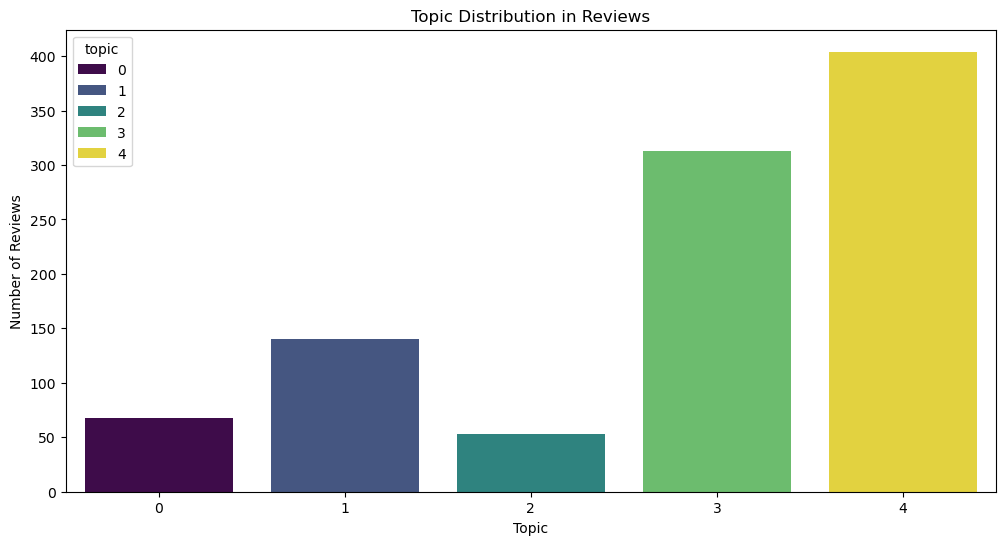

In [35]:
# Visualisasi distribusi topik
plt.figure(figsize=(12, 6))
sns.countplot(x='topic', data=df, hue = 'topic', palette='viridis')
plt.title('Topic Distribution in Reviews')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.savefig('Top Distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show();